In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.1.7.dev0


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import theano
import theano.tensor as tt
import exoplanet as xo

In [4]:
def get_L2(f, a, e, cosw, sinw, cosi, sini):
    cosf = tt.cos(f)
    sinf = tt.sin(f)
    e2 = e**2
    factor = (a * (e2 - 1) / (e*cosf + 1))**2
    return factor*(cosi**2*(cosw*sinf + sinw*cosf)**2 +
                           (cosw*cosf - sinw*sinf)**2)

egrid = np.linspace(0, 0.99, 51)
wgrid = np.linspace(-np.pi, np.pi, 71)
bgrid = np.linspace(0.0, 0.99, 4)

e, w, b = np.meshgrid(egrid, wgrid, bgrid)

a = 100 + np.zeros_like(e)
L = 1.1 * np.ones_like(e)

cosw = np.cos(w)
sinw = np.sin(w)
incl_factor = (1 + e * sinw) / (1 - e**2)
cosi = incl_factor * b * 1.0 / a
i = np.arccos(cosi)
sini = np.sin(i)

contact_op = xo.theano_ops.contact.ContactPointsOp(tol=1e-12)
kepler_op = xo.theano_ops.kepler.KeplerOp()
M1, M2, flag = contact_op(a, e, cosw, sinw, cosi, sini, L)
E1, f1 = kepler_op(M1, e)
E2, f2 = kepler_op(M2, e)

L1 = tt.sqrt(get_L2(f1, a, e, cosw, sinw, cosi, sini))
L2 = tt.sqrt(get_L2(f2, a, e, cosw, sinw, cosi, sini))

L1_val, L2_val, flag_val = theano.function([], [L1, L2, flag])()

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


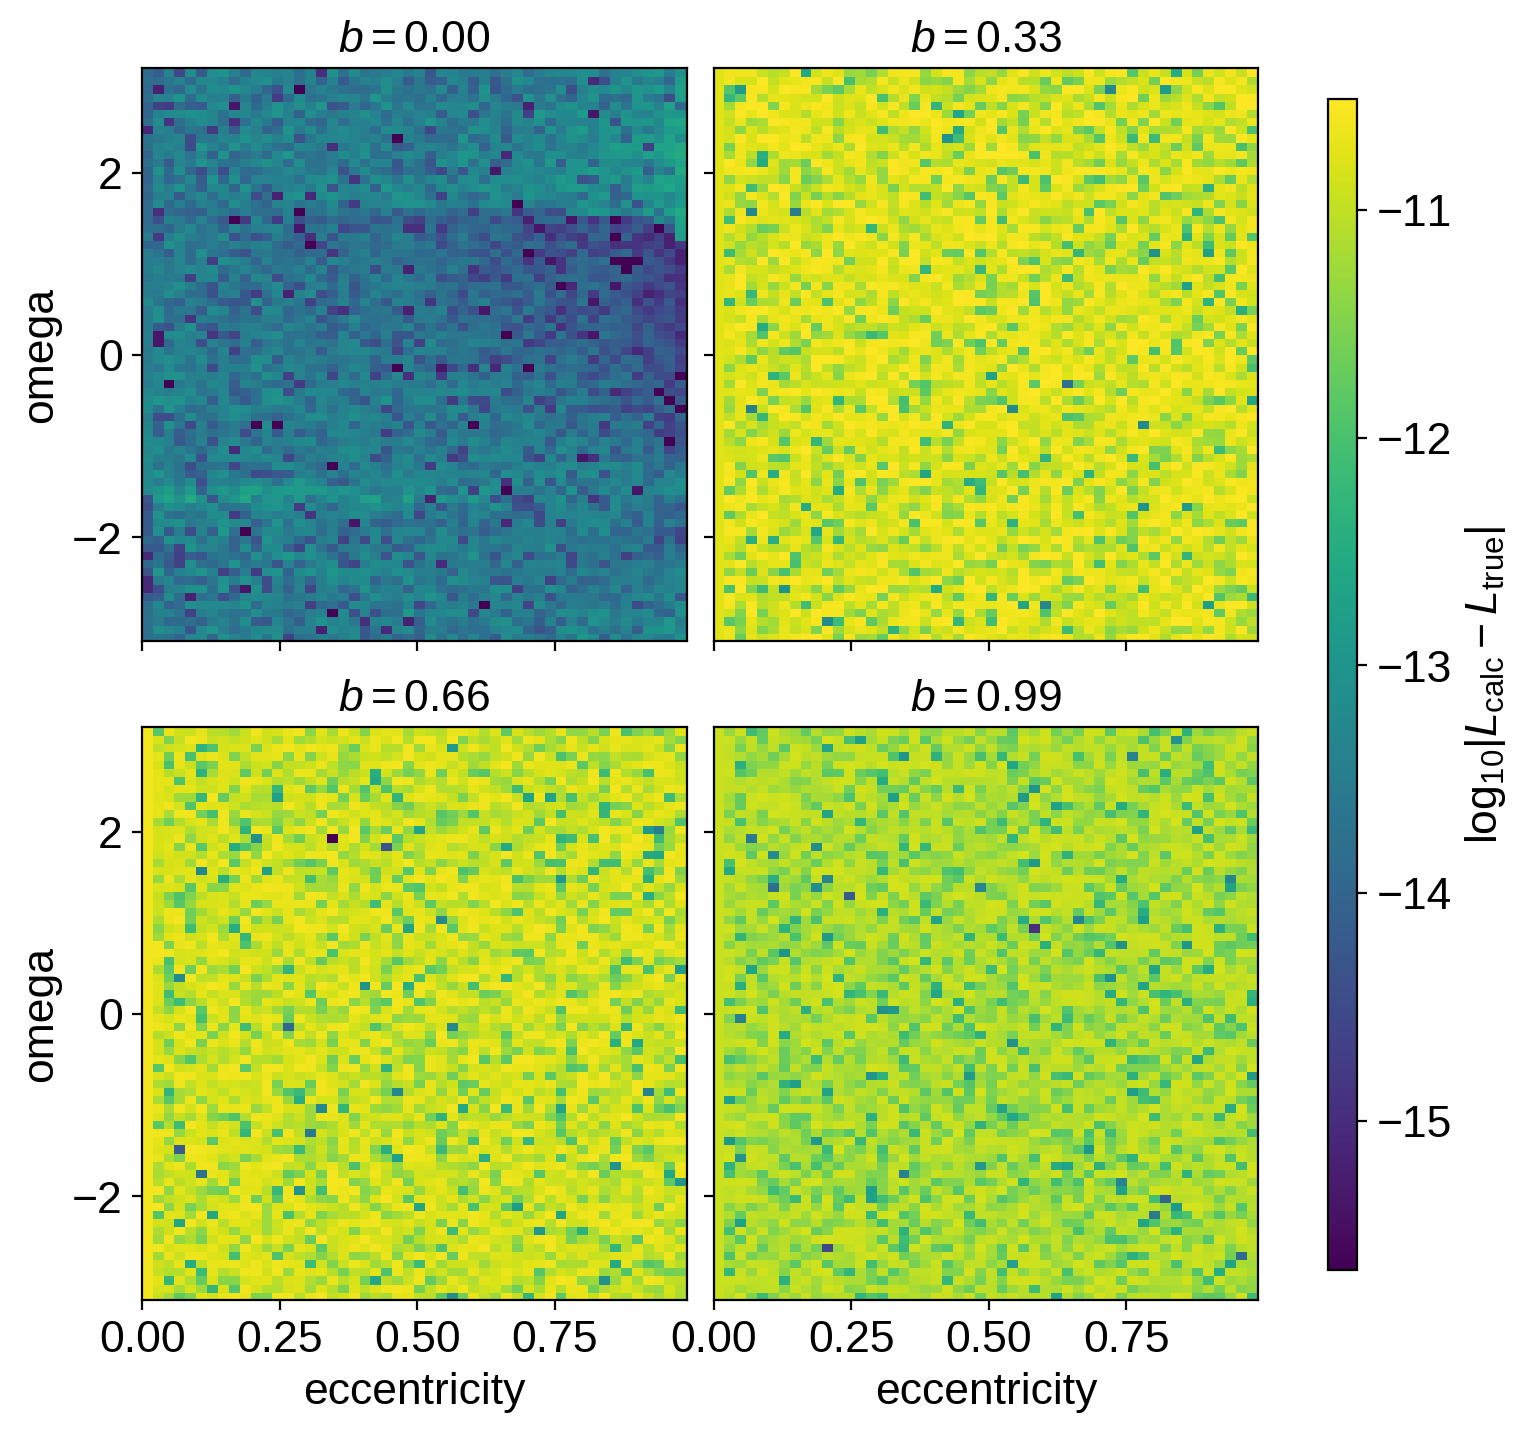

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(9, 8), sharex=True, sharey=True)
img = np.log10(np.abs(L1_val - L))
img[np.isinf(img)] = np.min(img[~np.isinf(img)])
img[flag_val != 0] = np.min(img)
vmin = np.min(img)
vmax = np.max(img)

for ind, ax in enumerate(axes.flat):
    art = ax.pcolor(egrid, wgrid, img[:, :, ind], vmin=vmin, vmax=vmax,
                    rasterized=True)
    ax.set_title("$b = {0:.2f}$".format(bgrid[ind]), fontsize=16)
    
fig.subplots_adjust(hspace=0.15, wspace=0.05)
fig.colorbar(art, ax=axes, aspect=40, shrink=0.95,
             label=r"$\log_{10}|L_\mathrm{calc} - L_\mathrm{true}|$")

for ax in axes[1, :]:
    ax.set_xlabel("eccentricity")
for ax in axes[:, 0]:
    ax.set_ylabel("omega")
    
fig.savefig("contact_points.pdf", bbox_inches="tight", dpi=300)